# Learning a sensorimotor model with a sensorimotor context

In this notebook, we will see how to use the Explauto libarary to allow the learning and control of local actions that depend on a sensory and motor context. We suppose that the reader is familiar with the main components of the Explauto library explained in another notebook ([full tutorial](http://nbviewer.ipython.org/github/flowersteam/explauto/blob/master/notebook/full_tutorial.ipynb)): the environment, the sensorimotor model and the interest model.

Another [tutorial](http://nbviewer.ipython.org/github/flowersteam/explauto/blob/master/notebook/Sensory_context.ipynb) describes how to define actions (not local) that only depends on a context provided by the environment.

Let's suppose we are in a motor state $m$ and a sensory state $s$.
If the goal is to reach a sensory state $s'$ from $s$, 
a *local* action $\Delta m$ has to be found, and $m + \Delta m$ will be evaluated in the environment.
The result of the command in the *environment* is defined as $(s, \Delta s)$, with $\Delta s = s' - s$.
Section I will show how to simply define an environment suited to the control of local actions from a usual Explauto environment.


In Section II we explain how the *sensorimotor model* is thus adapted to store and learn with tuples of $(m, \Delta m, s, \Delta s)$ instances.
We will explain different possibilities to query the sensorimotor model. 

To predict the result of an action in the environment, we can use a forward prediction of $\Delta s$ given $(m, \Delta m, s$.
To infer the right motor command that should best reach a sensory state $s'$, we can query $\Delta m$ from the sensorimotor model given $(m, s, \Delta s = s' - s)$. This use case is explained in Section V.

Another use case is to query $(m, \Delta m)$ from $(s, \Delta s)$. 
This can be used when the robot is allowed to choose the starting and end position of a movement $m \rightarrow m + \Delta m$ at each iteration of the learning algorithm. This use case is explained in Section IV.

An *interest model* is also used to estimate how a given action is useful for learning, and to sample the best ones.
In our case, if we are in a state $(m, s)$, the local action to be sampled is defined as $\Delta s$, and depends on $s$. In Section III we show how the interest models are adapted to this purpose.

In Sections IV and V, we explain how to automoatically create the environment, sensorimotor model, interest model and the learning procedure adapted to local actions with the class 'Experiment'.


# I. Environment

In this section we define an environment suited to the control of local actions from a usual Explauto environment.

We will use the available SimpleArm environment (this one is by default perturbated by a small random noise).

In [1]:
from explauto.environment.simple_arm import SimpleArmEnvironment
from explauto.environment import environments

env_cls = SimpleArmEnvironment
env_conf = environments['simple_arm'][1]['low_dimensional']

Now we use the class 'ContextEnvironment' to convert an Explauto environment that takes as input a motor position and outputs a sensory position to an environment that takes a motor command $\Delta m$ or $(m, \Delta m)$ and outputs a sensory position $(s, \Delta s)$.

To instanciate such an environment, one must provide the class and configuration of the underlying environment, and define a simple config for local actions called 'context_mode'.
The 'choose_m' parameter defines if the robot is allowed to choose $m$ and $\Delta m$ at each iteration instead of only $\Delta m$.
A rest position also has to be specified, and the bounds for the delta motor actions and delta sensory goals.

In [2]:
from explauto.environment.context_environment import ContextEnvironment

context_mode = dict(mode='mdmsds',
                    choose_m=False,
                    rest_position=[0]*3,
                    dm_bounds=[[-0.2, -0.2, -0.2],
                              [0.2, 0.2, 0.2]],
                    ds_bounds=[[-0.2, -0.2],
                              [0.2, 0.2]])

environment = ContextEnvironment(env_cls, env_conf, context_mode)

Here we sample and execute a few $\delta m$ actions.

Populating the interactive namespace from numpy and matplotlib


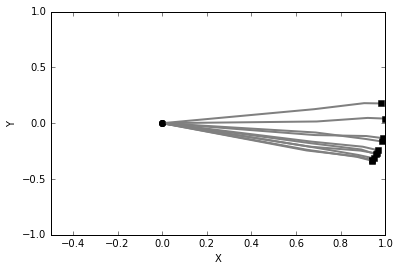

In [3]:
# Create the axes for plotting:
%pylab inline
ax = axes()

for dm in environment.random_dm(n=10):
    m = environment.current_motor_position
    mdm = np.hstack((m, dm))
    environment.update(mdm, reset=False)
    environment.plot(ax)

# II. Sensorimotor model

In this Section we show how to store the motor and sensory signals into the database and how to predict the result of an action. The inference of a motor action given a sensory goal is explicited later in Sections IV and V.

The adapted sensorimotor models are 'NN', 'LWLR-BFGS', and 'LWLR-CMAES' altough CMAES' exploration sigma and bounds might need to be adapted.
The database contains tuples of $(M, \Delta M, S, \Delta S)$ so we create the sensorimotor model with the dimensions and bounds of the environment.

In [4]:
from explauto import SensorimotorModel

sm_model = SensorimotorModel.from_configuration(environment.conf, 'nearest_neighbor', 'default')

In the following we ramdomly draw delta actions and update the sensorimotor model and the environment.

Populating the interactive namespace from numpy and matplotlib
Size of database: 1000


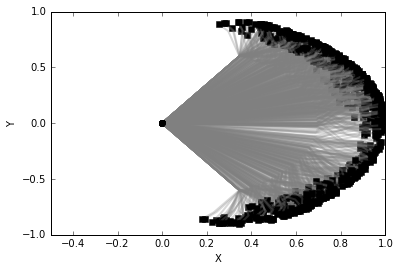

In [5]:
# Create the axes for plotting:
%pylab inline
ax = axes()

for dm in environment.random_dm(n=1000):
    m = environment.current_motor_position
    mdm = np.hstack((m, dm))
    sds = environment.update(mdm, reset=False)    
    sm_model.update(mdm, sds)
    environment.plot(ax, alpha=0.3)
    
print "Size of database:", sm_model.size()

Now we can query the sensorimotor model given $(m, \Delta m)$ and the context on given dimensions.
Let's say we want the hand y position to be considered as the context (but in more complex setups it could be the position of some objects in the environment).

In the plot, the black dot and red x are the predicted $s$ and $s'$ given the motor position $m$ and delta $\Delta m$, in the context c.
The corresponding reached arm positions are also represented.

Predicted s= [ 0.67680329 -0.6608312 ] predicted ds= [-0.03601064  0.04225289]


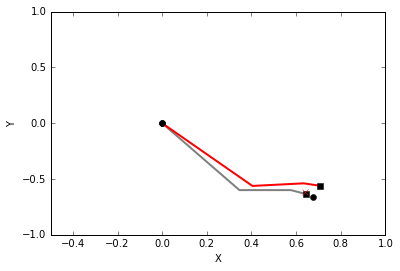

In [6]:
# Predict with sensori context
m = environment.current_motor_position
s = environment.current_sensori_position
dm = [0.1]*3
context = s # context
c_dims = [0, 1] # hand dimensions
sds = sm_model.predict_given_context(np.hstack((m, dm)), context, c_dims)
s = sds[0:2]
ds = sds[2:4]
print "Predicted s=", s, "predicted ds=", ds 

ax = axes()
environment.plot(ax)
environment.update(np.hstack((m, dm)), reset=False)
environment.plot(ax, color='red')
ax.plot(*s, marker='o', color='k')
ax.plot(*list(np.array(s)+np.array(ds)), marker='x', color='red')

# III. Goal babbling using interest models

In this section, we create an *interest model* that can sample given a context $s$ and output an interesting delta goal $\Delta s$ only on the dimensions that are not in the context.
This feature is implemented with the Random and Discretized interest models.

In [7]:
# Random interest model
from explauto.interest_model.random import RandomInterest

im_model = RandomInterest(environment.conf, environment.conf.s_dims)

In [8]:
# Discretized interest model
from explauto.interest_model.discrete_progress import DiscretizedProgress, competence_dist

im_model = DiscretizedProgress(environment.conf, environment.conf.s_dims, **{'x_card': 1000,
                                                     'win_size': 10,
                                                     'measure': competence_dist})

Sampling with context:

In [9]:
c = [0.7, 0.6] # context
c_dims = [0, 1] # hand position's dimensions

ds = im_model.sample_given_context(c, c_dims)

#print im_model.discrete_progress.progress()
print "Sampling interesting goal with hand position=", c, ": ds=", ds

Sampling interesting goal with hand position= [0.7, 0.6] : ds= [ 0.16025443  0.09275787]


# IV. Learning choosing m

In this section, we consider that the agent can choose the motor position $m$ at each iteration (parameter 'choose_m'=True).

Here we run the whole procedure without resetting the arm to its rest position during the experiment, first using motor babbling and after using goal babbling.

We also describe how to automatically create the environment, sensorimotor model, interest model and the learning procedure.

In [10]:
context_mode = dict(mode='mdmsds',
                    choose_m=True,
                    rest_position=[0]*3,
                    dm_bounds=[[-0.2, -0.2, -0.2],
                              [0.2, 0.2, 0.2]],
                    ds_bounds=[[-0.2, -0.2],
                              [0.2, 0.2]])

environment = ContextEnvironment(env_cls, env_conf, context_mode)

### Motor Babbling

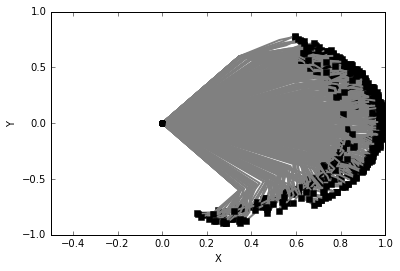

In [11]:
# Random Motor Babbling
ax = axes()
environment.reset()
motor_configurations = environment.random_dm(n=500)

# Plotting 10 random motor configurations:
for dm in motor_configurations:
    m = environment.current_motor_position
    environment.update(np.hstack((m, dm)), reset=False)
    environment.plot(ax)

### Goal Babbling

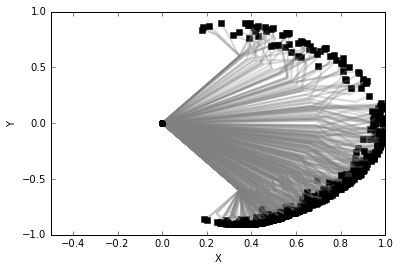

In [12]:
# Random Goal Babbling
im_model = RandomInterest(environment.conf, environment.conf.s_dims)

# Reset environment
environment.reset()

# Reset sensorimotor model
sm_model = SensorimotorModel.from_configuration(environment.conf, 'nearest_neighbor', 'default')

c_dims = [0, 1] # hand position's dimensions

# Add one point to boostrap sensorimotor model
sm_model.update([0.]*6, np.hstack((environment.current_sensori_position, [0., 0.])))
    
ax = axes()

for _ in range(500):
    # Get current context
    s = environment.current_sensori_position
    # sample a random sensory goal using the interest model:
    ds_g = im_model.sample_given_context(s, c_dims)
    # infer a motor command to reach that goal using the sensorimotor model:
    mdm = sm_model.inverse_prediction(np.hstack((s, ds_g)))
    # execute this command and observe the corresponding sensory effect:
    sds = environment.update(mdm, reset=False)
    # update the sensorimotor model:
    sm_model.update(mdm, sds)
    # update interest model
    im_model.update(hstack((mdm, s, ds_g)), hstack((mdm, sds)))
    # plot arm
    environment.plot(ax, alpha=0.3)
    

Here we test the learned sensorimotor model on a given goal ds_goal in sensory context s_goal. The agent chooses also the starting $m$ position.

In the plot, the black dot and red x are the goal $s$ and $s + \Delta s$.
The corresponding reached arm positions are represented.

501
Inverse without context: m = [ 0.39597765  0.35375602  0.68497614] dm = [ 0.0763439  -0.12497184  0.08074544]


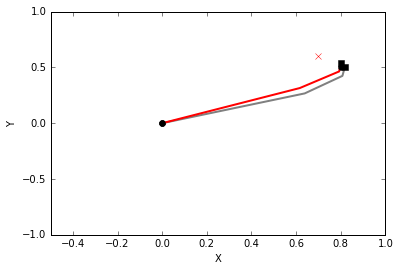

In [13]:
# Inverse without context: (M, dM) <- i(S, dS)
sm_model.mode = "exploit" # no exploration noise
print sm_model.size()
s_goal = [0.8, 0.5]
ds_goal = [-0.1, 0.1]
mdm = sm_model.inverse_prediction(s_goal + ds_goal)
m = mdm[0:3]
dm = mdm[3:6]
print "Inverse without context: m =", m, "dm =", dm 

ax = axes()
environment.update(np.hstack((m, [0]*3)))
environment.plot(ax)
environment.update(np.hstack((m, dm)), reset=False)
environment.plot(ax, color='red')
ax.plot(*s_goal, marker='o', color='k')
ax.plot(*list(np.array(s_goal)+np.array(ds_goal)), marker='x', color='red')

## Using 'Experiment'

Populating the interactive namespace from numpy and matplotlib


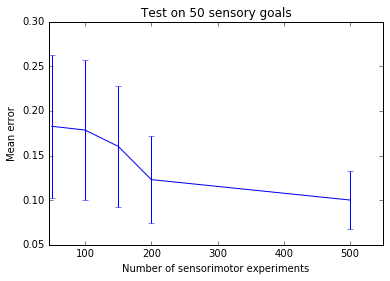

In [14]:
import numpy as np
from explauto import Agent
from explauto import Experiment
from explauto.utils import rand_bounds
from explauto.experiment import make_settings
%pylab inline

context_mode = dict(mode='mdmsds',
                    choose_m=True,
                    rest_position=[0]*3,
                    dm_bounds=[[-0.2, -0.2, -0.2],
                              [0.2, 0.2, 0.2]],
                    ds_bounds=[[-0.2, -0.2],
                              [0.2, 0.2]])

goal_babbling = make_settings(environment='simple_arm', environment_config = 'low_dimensional',
                                     babbling_mode='goal', 
                                     interest_model='discretized_progress',
                                     sensorimotor_model='nearest_neighbor',
                                     context_mode=context_mode)

expe = Experiment.from_settings(goal_babbling)

expe.evaluate_at([50, 100, 150, 200, 500], 
                 rand_bounds(np.vstack(([0.8, -0.1, -0.1, -0.2], [1., 0.1, 0.1, 0.2])), n=50))

expe.run()

ax = axes()
expe.log.plot_learning_curve(ax)

# V. Learning without choosing m

In this section, we consider that the agent can't choose the motor position $m$ at each iteration (parameter 'choose_m'=False). In that case, the environment can be resetted to the rest position each N iterations if the parameter 'reset_iterations' is provided in 'context_mode'.

Here we run the whole procedure first using motor babbling and after using goal babbling.

We also describe how to automatically create the environment, sensorimotor model, interest model and the learning procedure.

In [15]:
from explauto.environment.context_environment import ContextEnvironment
from explauto.environment.simple_arm import SimpleArmEnvironment
from explauto.environment import environments

env_cls = SimpleArmEnvironment
env_conf = environments['simple_arm'][1]['low_dimensional']

context_mode = dict(mode='mdmsds',
                    choose_m=False,
                    rest_position=[0]*3,
                    reset_iterations=20,
                    dm_bounds=[[-0.2, -0.2, -0.2],
                              [0.2, 0.2, 0.2]],
                    ds_bounds=[[-0.2, -0.2],
                              [0.2, 0.2]])

environment = ContextEnvironment(env_cls, env_conf, context_mode)

### Motor Babbling

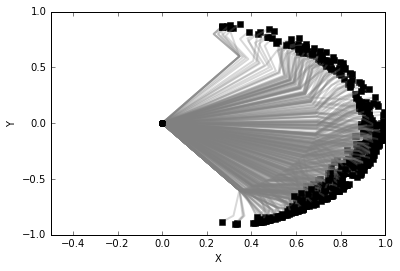

In [16]:
# Random Motor Babbling
ax = axes()
environment.reset()
motor_configurations = environment.random_dm(n=500)

for dm in motor_configurations:
    
    m = list(environment.current_motor_position)
    environment.update(np.hstack((m, dm)), reset=False)
    environment.plot(ax, alpha=0.3)

### Goal Babbling

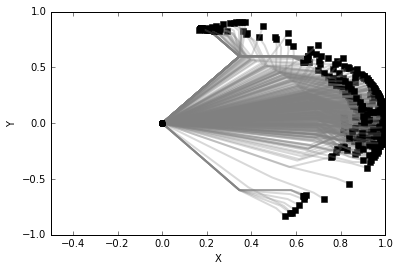

In [17]:
ax = axes()

# Random Goal Babbling
im_model = RandomInterest(environment.conf, environment.conf.s_dims)

# Reset environment
environment.reset()

# Reset sensorimotor model
sm_model = SensorimotorModel.from_configuration(environment.conf, 'nearest_neighbor', 'default')

# Add points to boostrap sensorimotor model
for i in range(10):
    sm_model.update([0.]*6, np.hstack((environment.current_sensori_position, [0., 0.])))
  

in_dims = range(3) + range(6,10)
out_dims = range(3, 6)

for i in range(500):
    if np.mod(i, context_mode['reset_iterations']) == 0:
        environment.reset()
    m = list(environment.current_motor_position)
    s = list(environment.current_sensori_position)

    ds_g = list(im_model.sample_given_context(s, range(environment.conf.s_ndims/2)))
    #print "ds_g", ds_g

    dm = sm_model.infer(in_dims, 
                        out_dims, 
                        m + s + ds_g)
    mdm = np.hstack((m, dm))
    #print "mdm", mdm
    sds = environment.update(mdm, reset=False)
    # update the sensorimotor model:
    sm_model.update(mdm, sds)
    # update interest model
    im_model.update(np.hstack((mdm, s, ds_g)), np.hstack((mdm, sds)))
    # plot arm
    environment.plot(ax, alpha=0.3)
    #print "m", m, "s", s, "ds_g", ds_g, "dm", dm
    

Here we test the learned sensorimotor model on a given goal ds_goal in sensory context s_current. 

In the plot, the black dot and red x are the current $s$ and goal $s + \Delta s$.
The corresponding reached arm positions are represented.

current m =  [0.10000000000000001, 0.10000000000000001, 0.10000000000000001]
current s =  [0.97165652415804871, 0.13866435452818074]
Inverse with context: dm = [ 0.05346364 -0.08287875 -0.02834013]
Goal ds= [-0.05, 0.1] Reached ds= [ 0.07387314  0.0208759 ]


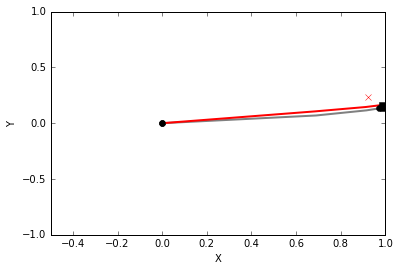

In [18]:
# Inverse with sensorimotor context: dM <- i(M, S, dS)
ax = axes()
dm = [0.1]*3
environment.update(np.hstack(([0]*3, dm)))
environment.plot(ax)

in_dims = range(3) + range(6,10)
out_dims = range(3, 6)
ds_goal = [-0.05, 0.1]

m_current = list(environment.current_motor_position)
s_current = list(environment.current_sensori_position)
print "current m = ", m_current
print "current s = ", s_current

dm = sm_model.infer(in_dims, 
                    out_dims, 
                    m_current + s_current + ds_goal)

print "Inverse with context: dm =", dm 
sds = environment.update(np.hstack((m_current, dm)), reset=False)
environment.plot(ax, color='red')
ax.plot(*s_current, marker='o', color='k')
ax.plot(*list(np.array(s_current) + np.array(ds_goal)), marker='x', color='red')

print "Goal ds=", ds_goal, "Reached ds=", environment.current_sensori_position - s_current




## Using 'Experiment'

Populating the interactive namespace from numpy and matplotlib


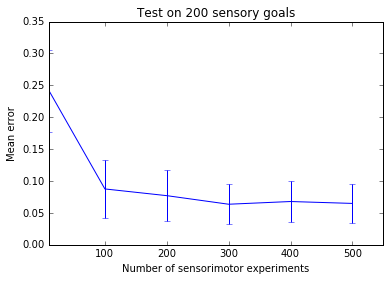

In [19]:
import numpy as np
from explauto import Agent
from explauto import Experiment
from explauto.utils import rand_bounds
from explauto.experiment import make_settings
%pylab inline

n_dims = 3

context_mode = dict(mode='mdmsds',
                    choose_m=False,
                    reset_iterations=20,
                    rest_position=[0]*n_dims,
                    dm_bounds=[[-0.2]*n_dims,
                              [0.2]*n_dims],
                    ds_bounds=[[-0.2, -0.2],
                              [0.2, 0.2]])

goal_babbling = make_settings(environment='simple_arm', environment_config = 'low_dimensional',
                                     babbling_mode='goal', 
                                     interest_model='random',
                                     sensorimotor_model='nearest_neighbor',
                                     context_mode=context_mode)

expe = Experiment.from_settings(goal_babbling)
expe.evaluate_at([10, 100, 200, 300, 400, 500], 
                 rand_bounds(np.vstack(([1., 0., -0.1, -0.1], [1., 0., 0., 0.1])), n=200))

    
expe.run()

ax = axes()
expe.log.plot_learning_curve(ax)

# Possible extensions

 - choosing s at each iteration
 - multistep planning